In [ ]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [ ]:
def f_simple_sum(circ, lista):
    
    #This function adds two elements and stores it in a third one
    #It's usefull for Qi + Qj = 1 restrictions. 
    
    for array in lista:
        circ.cx(array[0], array[2])
        circ.cx(array[1], array[2])
        circ.barrier(range(numero_qubits))
        
        
def f_sum_not_two(circ, lista):
    
    #This function store in the solution qubit the value |1> if the sum of the
    #two first qubits is 0 or 1. We will use it for Qi + Qj < 2
    
    for array in lista:
        circ.x(array[2])
        circ.ccx(array[0],array[1],array[2])
        circ.barrier(range(numero_qubits))
        
def f_sum_three_is_one(circ, lista):
    
    # This function check that the sum of the first three qubits is one.
    # We will use it for de Qi + Qj +Qk = 1
    
    for array in lista:
        
        circ.cx(array[0],array[3])
        circ.cx(array[1],array[3])
        circ.cx(array[2],array[3])
        circ.ccx(array[0],array[1],array[4])
        circ.ccx(array[2],array[4],array[3])
        circ.ccx(array[0],array[1],array[4])
        circ.barrier(range(numero_qubits))
def f_check_all_one(circ,lista):
    
    # if the first len(lista)/2 qubits are |1>, this function mark the
    # qubit solution with a |1> too.
    # It's usefull for check that all previous conditions are met.
    
    for array in lista:
        circ.ccx(array[0],array[1],array[8])
        for i in range(6):
            circ.ccx(array[2 + i], array[8 + i], array[9 + i])
        
        circ.cx(array[-2], array[-1])
        
        for i in range(5,-1,-1):
            circ.ccx(array[2 + i], array[8 + i], array[9 + i])
        circ.ccx(array[0],array[1],array[8])
        circ.barrier(range(numero_qubits))

def add_grover(circ, free):
    
    # with this function we add the Grover operator
    
    lista = list(range(6)) # list of unknow qubits
    
    firts_free_qubit = free
            
    circ.h(lista)
    circ.x(lista)
    circ.barrier(range(numero_qubits))

    circ.ccx(lista[0], lista[1], firts_free_qubit)
    
    for i in range(len(lista) - 3):
        circ.ccx(lista[i+2],firts_free_qubit + i, firts_free_qubit + 1 + i)
        j = i
        
    circ.cz(firts_free_qubit + 1 + j,lista[-1])
    
    for i in range(len(lista) - 4, -1, -1):
        circ.ccx(lista[i+2],firts_free_qubit + i, firts_free_qubit + 1 + i)
    
    circ.ccx(lista[0], lista[1], firts_free_qubit)
    circ.barrier(range(numero_qubits))

    circ.x(lista)
    circ.h(lista)
    circ.barrier(range(numero_qubits))


    return 0

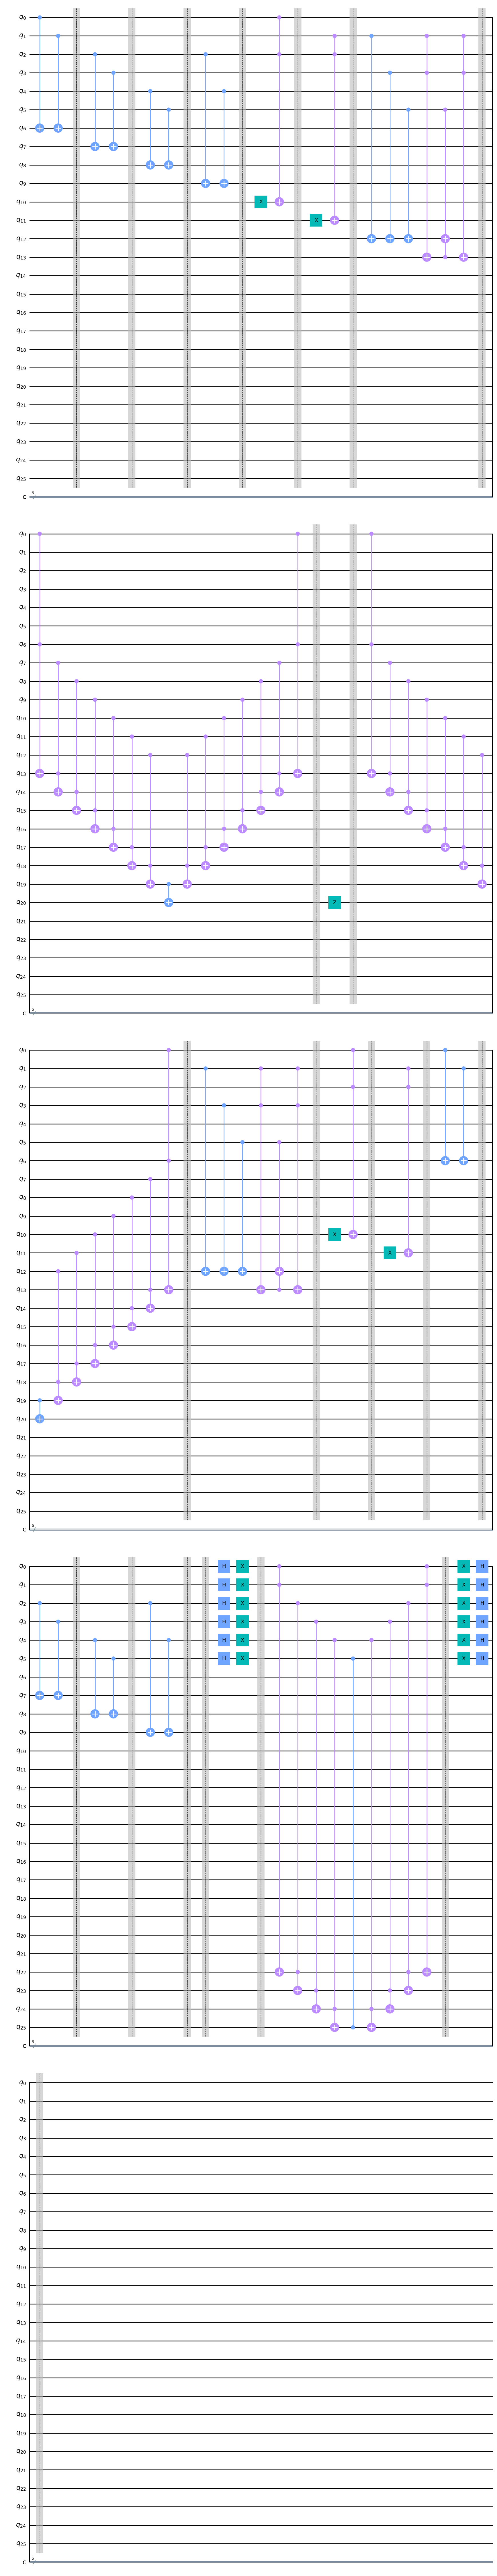

In [ ]:
simple_sum = [ # first qubits plus the second, and we store the solution in the third qubit
    [0,1,6],
    [2,3,7],
    [4,5,8],
    [2,4,9]
]

diagonals = [ # third qubit = 1 iff the sum of the others is less than 2
    [0,2,10],
    [1,2,11]
]

three_sum = [ # fourth qubit = 1 iff the sum of the first three qubits is 1.
    [1,3,5,12,13]  # the last qubits is an auxiliar qubit.
]
numero_qubits = 26 # number of qubits

circ = QuantumCircuit(numero_qubits, 6)

f_simple_sum(circ,simple_sum)
f_sum_not_two(circ, diagonals)
f_sum_three_is_one(circ, three_sum)


criteria_solutions = [[0,6,7,8,9,10,11,12, 13,14,15,16,17,18,19,20]] # 8-7-1
          # 0~7: the qubits we want to check if are |1>
          # 8~14: ancillas
          # 15: qubit that store the answer
            
            
f_check_all_one(circ, criteria_solutions)

circ.z(20) # if the output of the previous function is |1>, we change the sign of the state

circ.barrier(range(numero_qubits))

# Here, we are going to undo the previous operations because we have to reset all auxiliar qubits to |0>
f_check_all_one(circ, criteria_solutions)
f_sum_three_is_one(circ, three_sum)
f_sum_not_two(circ, diagonals)
f_simple_sum(circ,simple_sum)

circ.barrier(range(numero_qubits))


add_grover(circ, 22)

circ.draw()

In [ ]:
circuito = QuantumCircuit(numero_qubits,6)

# we create the superposition of all possible states
circuito.h(range(6))

# We are working with 2⁶ states (64), so the algorithm will be repeated sqrt(64) = 8 times
for _ in range(8):
    circuito = circuito.compose(circ)
circuito.measure(range(6),range(6))

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")
sampler = Sampler(backend)
job = sampler.run(circuito)
job.result()

SamplerResult(quasi_dists=[{53: 0.00425, 3: 0.0035, 11: 0.004, 56: 0.005, 31: 0.0055, 47: 0.003, 41: 0.003, 52: 0.00275, 34: 0.00425, 63: 0.00425, 36: 0.005, 58: 0.005, 6: 0.00375, 46: 0.005, 40: 0.00525, 14: 0.0045, 45: 0.004, 1: 0.0055, 13: 0.005, 7: 0.0045, 28: 0.00425, 49: 0.00425, 55: 0.00325, 9: 0.00625, 62: 0.0055, 42: 0.0045, 26: 0.0045, 48: 0.00525, 33: 0.00575, 37: 0.00425, 39: 0.0035, 61: 0.0045, 25: 0.714, 35: 0.00525, 23: 0.00625, 20: 0.0035, 24: 0.00575, 0: 0.00225, 43: 0.00525, 17: 0.00475, 4: 0.005, 5: 0.00425, 19: 0.0055, 8: 0.00575, 60: 0.004, 51: 0.0045, 32: 0.00425, 29: 0.00525, 50: 0.0025, 22: 0.00575, 16: 0.00325, 59: 0.00475, 12: 0.00625, 38: 0.00375, 57: 0.004, 21: 0.0065, 44: 0.0055, 2: 0.006, 10: 0.0025, 30: 0.00375, 18: 0.00375, 15: 0.00525, 54: 0.0045, 27: 0.00375}], metadata=[{'shots': 4000}])

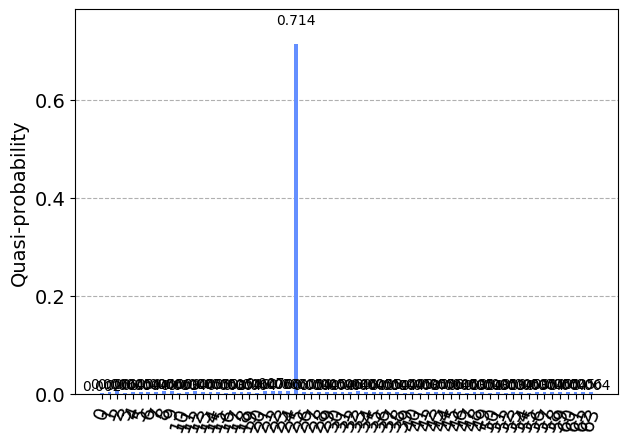

In [18]:
from qiskit.visualization import plot_histogram
plot_histogram(
    job.result().quasi_dists
)